In [1]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [2]:
print(post)

<li class="result-row" data-pid="7142146015" data-repost-of="6844338507">
<a class="result-image gallery" data-ids="1:00M0M_1gpLdnHpRa0,1:00j0j_8IIereHdXfy,1:00M0M_7YM4yViIkIX,1:00r0r_2o0yVHcPbpo,1:00505_bW8Y5B6MjjB,1:01111_lqkGw6JnWrD" href="https://minneapolis.craigslist.org/ram/apa/d/saint-paul-unique-designs-dramatic/7142146015.html">
<span class="result-price">$1597</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-06-15 10:26" title="Mon 15 Jun 10:26:52 AM">Jun 15</time>
<a class="result-title hdrlnk" data-id="7142146015" href="https://minneapolis.craigslist.org/ram/apa/d/saint-paul-unique-designs-dramatic/7142146015.html">Unique Designs, Dramatic Flair, Chefs Kitchen, Exceptional Amenities</a>
<span class="result-meta">
<span class="result-price">$1597</span>
<span class="housing">
                    2br -
                    1087ft<sup>2</su

In [3]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-06-15 10:26
https://minneapolis.craigslist.org/ram/apa/d/saint-paul-unique-designs-dramatic/7142146015.html


In [4]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (Highland Park, St. Paul)


In [5]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)





import numpy as np

loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

44.925753,-93.132820


GeocoderTimedOut: Service timed out

In [ ]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

In [ ]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [ ]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

In [227]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np


citystr = 'minneapolis' ## 'washingtondc' #'minneapolis'
linkpfx = 'https://'+citystr+'.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=20'
          +'&postal=55454' #55454' #DC: 20009
          +'&min_price=300'
          +'&max_price=8000'
          +'&max_bedrooms=4'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=5)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        #sleep(1.1)
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./apts_'+citystr+"_"+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


(77, 14)

In [228]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [229]:
import os
import glob
citystr = 'minneapolis' #'minneapolis', 'washingtondc'

aptfiles = glob.glob('apts_'+citystr+'*')


try:
    del apts
except:
    print('no apts in memory, loading some...')


for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts = apts[apts['sqft']<5000]

apts.shape

(1440, 14)

In [230]:
apts[apts['sqft']>5000]

Empty DataFrame
Columns: [posted, neighborhood, post title, number bedrooms, sqft, URL, price, cities, towns, neighborhoods, zips, types, parking, laundry]
Index: []

In [231]:
apts.describe()

number bedrooms         sqft       price        types      parking  \
count      1423.000000  1440.000000  1440.00000  1427.000000  1252.000000   
mean          1.756149  1005.514583  1484.72500     1.998598     2.829872   
std           0.793071   421.919572   565.41541     2.240141     1.029836   
min           1.000000   103.000000   475.00000     1.000000     1.000000   
25%           1.000000   730.000000  1107.25000     1.000000     2.000000   
50%           2.000000   890.500000  1400.00000     1.000000     2.000000   
75%           2.000000  1179.250000  1695.00000     1.000000     4.000000   
max           5.000000  3521.000000  6495.00000     9.000000     7.000000   

           laundry  
count  1345.000000  
mean      2.037175  
std       1.136561  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       3.000000  
max       5.000000

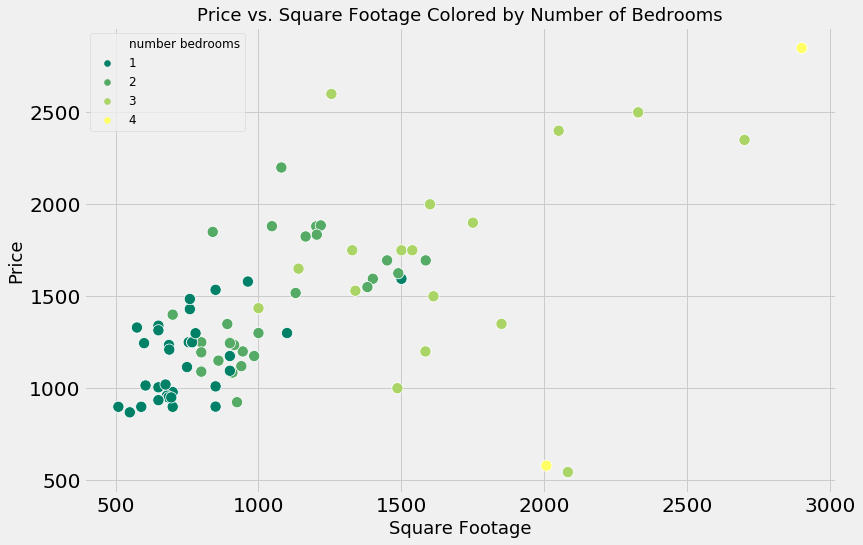

In [232]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


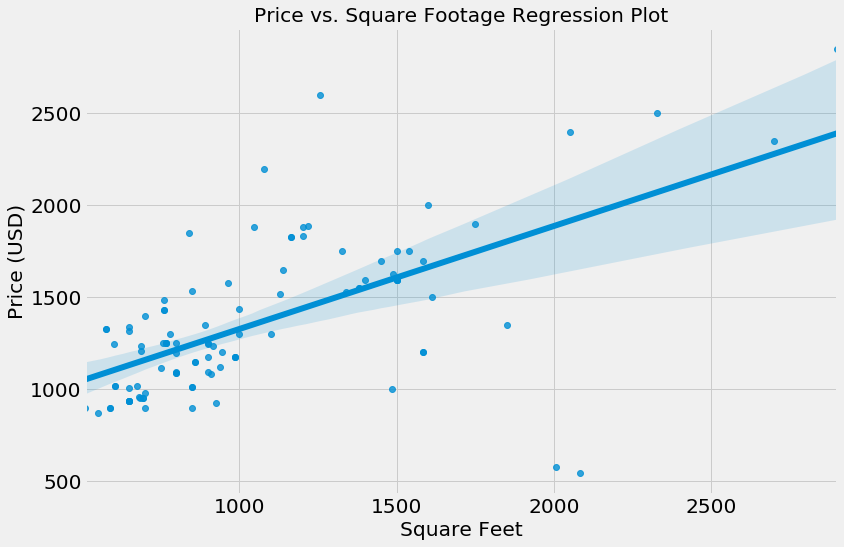

In [233]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [234]:
apts.corr()

number bedrooms      sqft     price     types   parking  \
number bedrooms         1.000000  0.778132  0.364576  0.462270 -0.047167   
sqft                    0.778132  1.000000  0.510173  0.523826 -0.189031   
price                   0.364576  0.510173  1.000000  0.125260 -0.303509   
types                   0.462270  0.523826  0.125260  1.000000 -0.139145   
parking                -0.047167 -0.189031 -0.303509 -0.139145  1.000000   
laundry                -0.153710 -0.267498 -0.441095 -0.248890  0.528294   

                  laundry  
number bedrooms -0.153710  
sqft            -0.267498  
price           -0.441095  
types           -0.248890  
parking          0.528294  
laundry          1.000000

In [235]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

number bedrooms    sqft   price  types  \
neighborhoods                                                             
Apple Valley                                 1.0   858.0  1219.0    1.5   
Aquila                                       1.0   815.0  1025.0    1.5   
Audubon Park                                 1.0   800.0   890.0    2.0   
Avenida                                      1.0  1342.0  1772.5    9.0   
Bancroft                                     1.0   536.0   940.0    1.0   
Birchwood                                    1.0   660.0  1045.0    1.0   
Blackstone                                   1.0   725.0  1693.0    1.0   
Bloomington                                  1.0   752.0  1177.5    1.0   
Bottineau                                    1.0   722.0  1647.5    1.0   
Bredesen Park                                1.0   767.0  1499.0    1.0   
Brooklyn Park                                1.0   775.0   975.0    1.0   
Brookside                                    1.0   672.0  1290.0    1.0   
Bryn Mawr                                    1.0   535.0  1022.5    2.0   
Burnsville                                   1.0   786.0  1075.0    1.0   
CARAG                                        1.0   650.0  1000.0    1.0   
Cedar-Isles-Dean                             1.0   770.0  1585.0    1.0   
Central                                      1.0   690.0  1100.0    1.0   
Champlin                                     1.0   720.0  1121.0    NaN   
Chanhassen                                   1.0   700.0   840.0    1.0   
Cornelia South                               1.0   725.0  1390.0    1.0   
Diamond Lake                                 1.0   687.5  1055.0    1.0   
Eagan                                        1.0   752.0  1250.0    1.0   
East Calhoun                                 1.0   684.0  1622.5    1.0   
East Isles                                   1.0   750.0  1095.0    1.0   
Eden Prairie                                 1.0   760.0  1215.0    1.0   
Edinborough                                  1.0   900.0  1095.0    2.0   
Excelsior                                    1.0   680.0  1035.0    1.0   
Falcon Heights                               1.0   630.0  1497.0    1.0   
Fern Hill                                    1.0   720.0  1170.0    1.0   
Fulton                                       1.0  1500.0  1595.0    6.0   
Golden Valley                                1.0   800.0  1190.0    1.0   
Hamline-Midway                               1.0   678.0   899.5    1.0   
Hiawatha                                     1.0   833.0  1445.0    1.0   
Highland Village                             1.0   727.5  1075.0    1.0   
Hilltop                                      1.0   725.0  1197.5    1.0   
Holland                                      1.0   710.0  1299.0    NaN   
Hopkins                                      1.0   670.0  1025.0    1.0   
Kilmer                                       1.0  1000.0  1250.0    6.0   
Kingfield                                    1.0   620.0   957.5    1.0   
Lakeville                                    1.0   760.0  1457.5    1.0   
Linden Hills                                 1.0   600.0  1150.0    1.0   
Little Canada                                1.0   735.0   935.0    2.0   
Logan Park                                   1.0   325.0   750.0    2.0   
Loring Park                                  1.0   509.0  1059.0    1.0   
Lowry Hill East                              1.0   609.0  1067.5    1.0   
Lyndale                                      1.0   760.0  1457.5    1.0   
Maplewood                                    1.0   684.0   994.5    1.0   
Marcy-Holmes                                 1.0   612.0  1590.0    1.0   
McKinley                                     1.0   850.0   600.0    1.0   
Minneapolis                                  1.0   600.0  1100.0    1.0   
Minnehaha                                    1.0   757.0  1370.0    1.0   
Minnetonka                                   1.0   760.0  

In [236]:
#correct oddly named locations
apts['neighborhoods'].replace('Uptown Minneapolis', 'Uptown', inplace=True)

apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

neighborhoods
McKinley                            600.0
Powderhorn Park                     735.0
Logan Park                          750.0
Victory                             775.0
Chanhassen                          840.0
Audubon Park                        890.0
Phillips West                       897.5
Hamline-Midway                      899.5
Windom                              925.0
Little Canada                       935.0
Richfield                           935.0
Southdale                           937.0
Bancroft                            940.0
Kingfield                           957.5
South St. Paul                      960.0
Brooklyn Park                       975.0
Triangle                            975.0
Maplewood                           994.5
New Hope                            995.0
CARAG                              1000.0
Rondo                              1005.0
St. Paul                           1015.0
Bryn Mawr                          1022.5
Roseville           

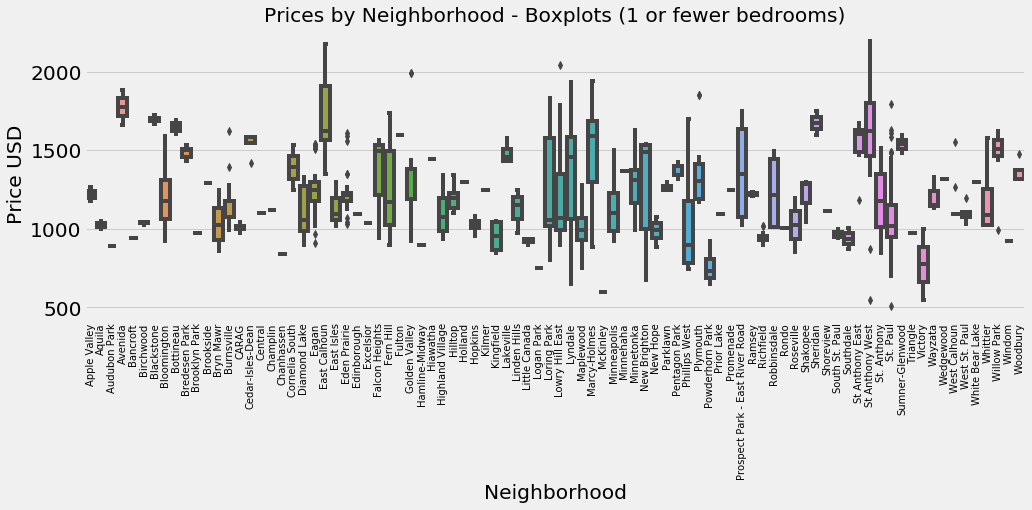

In [237]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim],
           order=sorted(apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()))
plt.xlabel("Neighborhood");
plt.xticks(rotation=90,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [238]:
# drop problematic cols
apts = apts.dropna(subset=['price','number bedrooms','sqft','neighborhoods','types','laundry','parking'])
print(apts.shape)

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])

#print(apts_onehot)

(1224, 14)


In [239]:
from sklearn import preprocessing
from sklearn import linear_model

maincols = ['number bedrooms','sqft']
#nbcols = [col for col in apts_onehot if col.startswith('ct')]
#for c in nbcols:
#    maincols.append(c) 
nbcols = [col for col in apts_onehot if col.startswith('nb')]
for c in nbcols:
    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in tycols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in pkcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in ldcols:
    maincols.append(c) 

# set up regression
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
thresh = .5 # drop columns that correlate above this value
cor = np.abs(np.corrcoef(X.T))
p = np.argwhere(np.triu(np.isclose(cor,1),1))
X = np.delete(X,p[:,1],axis=1)
X = preprocessing.scale(X)

#OLS
reg = linear_model.LinearRegression()
reg.fit(y=y,X=X)
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

# Ridge regression approach
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [.005, .01, .025, .05, .10, .5, 1, 2.5, 5, 10, 20, 40, 50,100,200,400,800,1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X=X,y=y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
apts_onehot['price_est'] = ridge_regressor.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100


{'alpha': 100}
-154467.02594674344


In [240]:
X.shape

(1224, 155)

In [241]:
apts_onehot['price_difpct']

0      -12.880908
1       -6.139064
2        7.379133
3        2.345658
4        5.787310
          ...    
2245     8.605425
2246     0.839168
2247     9.976496
2248    -0.919964
2249    -6.301823
Name: price_difpct, Length: 1224, dtype: float64

In [242]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 600

apts_onehot[(apts_onehot['price_difpct']<=5) & 
            (apts_onehot['sqft']>=749) & 
            (apts_onehot['price']<=1100) & 
            (apts_onehot['number bedrooms']<=2)].sort_values('price_difpct',ascending=True)['URL'] 

1314                      https://minneapolis.craigslist.org/wsh/apa/d/saint-paul-sweet-home/7137776465.html
1469            https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-one-bedroom-and-one/7122664994.html
1232         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-umn-student-housing-in/7137535002.html
1463     https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-located-right-in-the-heart/7128904675.html
1056         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-just-move-in-and-relax/7137217175.html
1455          https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-beautifully-updated-1/7133294599.html
1052     https://minneapolis.craigslist.org/csw/apa/d/minneapolis-nicely-updated-2bd-rambler/7137209110.html
806       https://minneapolis.craigslist.org/ram/apa/d/saint-paul-2-bedroom-1300-july-august/7136430780.html
2157        https://minneapolis.craigslist.org/ram/apa/d/saint-paul-800-2br-ft2-you-can-rent/7142586547.html
257     https://min

In [243]:
#Prepare data:
prices = np.array(apts_onehot['price'])
features = np.array(apts_onehot[maincols])
feature_list = list(apts_onehot[maincols])

In [244]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, prices, test_size = 0.10, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1101, 155)
Training Labels Shape: (1101,)
Testing Features Shape: (123, 155)
Testing Labels Shape: (123,)


In [245]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [246]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2), '.')

Mean Absolute Error: $ 147.48 .


In [247]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 89.89 %.


In [248]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [249]:
from IPython.display import Image 
Image("tree.png")

In [250]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sqft                 Importance: 0.47
Variable: ty_2.0               Importance: 0.11
Variable: ld_1.0               Importance: 0.09
Variable: number bedrooms      Importance: 0.05
Variable: nb_East Calhoun      Importance: 0.02
Variable: nb_Marcy-Holmes      Importance: 0.02
Variable: nb_St Anthony West   Importance: 0.02
Variable: nb_West Calhoun      Importance: 0.02
Variable: ty_1.0               Importance: 0.02
Variable: ty_6.0               Importance: 0.02
Variable: nb_Cedar-Isles-Dean  Importance: 0.01
Variable: nb_Fern Hill         Importance: 0.01
Variable: nb_Lowry Hill East   Importance: 0.01
Variable: nb_Lyndale           Importance: 0.01
Variable: nb_St Anthony East   Importance: 0.01
Variable: nb_St. Paul          Importance: 0.01
Variable: pk_1.0               Importance: 0.01
Variable: pk_2.0               Importance: 0.01
Variable: pk_4.0               Importance: 0.01
Variable: nb_Anoka             Importance: 0.0
Variable: nb_Apple Valley      Importance